# Lab 3 - Self-supervised learning, clusters and augmentation

# Plan for today

* train a classifier using a small number of examples
* explore the embedding space of a classifier
* learn about intuition behind entropy
* explore different techniques for improving classification results
    * data augmentation
    * self-supervised learning

In [1]:
from torch.optim import SGD
from torch import nn
import torch
from typing import List
from torchvision.datasets import MNIST
from torchvision import transforms as tv
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from time import sleep
from torchvision.models import vgg16, vgg16_bn, resnet50, resnet18
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
from typing import Tuple

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/tadeusz/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

Today we will work with the MNIST dataset. However, we will use only a few labeled examples per-class to train our model.

In [3]:
ds_full = MNIST(root="data", train=True, download=True, transform=tv.ToTensor())

ds_test = MNIST(root="data", train=False, download=True, transform=tv.ToTensor())

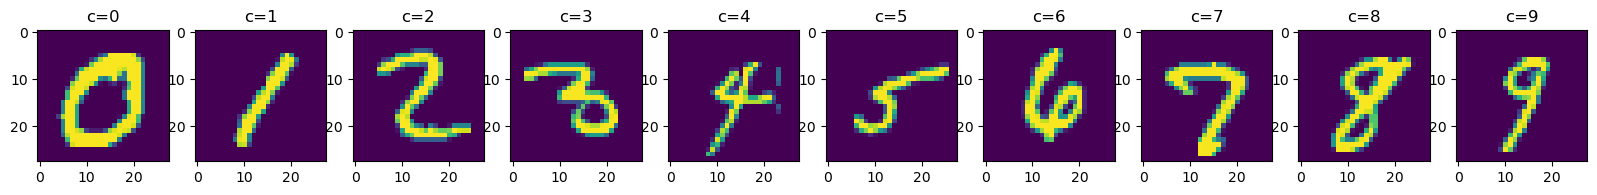

In [4]:
labeled_indices = []
unlabeled_indices = []

n = 5

label_counter = defaultdict(int)

for i, (X, y) in enumerate(ds_full):
  if label_counter[y] < n:
    labeled_indices.append(i)
    label_counter[y] += 1
  else:
    unlabeled_indices.append(i)
  
    
ds_labeled_small = Subset(ds_full, labeled_indices)
ds_unlabeled = Subset(ds_full, unlabeled_indices)

assert len(ds_labeled_small) == 10*n

assert len(set(labeled_indices).intersection(set(unlabeled_indices))) == 0
    
fig, ax = plt.subplots(ncols=10, figsize=(20, 15))

for (X,y) in ds_labeled_small:
  ax[y].imshow(X.permute(1,2,0))
  ax[y].set_title(f"c={y}")
plt.show()

In [5]:
batch_size=128
dl_train_full = DataLoader(ds_full, batch_size, shuffle=True, drop_last=False) # dataloader with full dataset 
dl_train_labeled = DataLoader(ds_labeled_small, batch_size, shuffle=True, drop_last=False) # dataloader with partial dataset
dl_train_unlabeled = DataLoader(ds_unlabeled, batch_size*4, shuffle=True) # dataloader with "unlabeled" part of the dataset

dl_test = DataLoader(ds_test, batch_size, shuffle=False)


In [6]:
class Net(nn.Module):
  def __init__(self, hidden_sizes: List[int], downsize_steps: List[int], in_hw: int = 28, n_classes: int = 10, in_channels=1):
    """
    Args:
      hidden sizes - hidden size of each consecutive convolution
      downsize_steps - numbers of convolutions for which there will be stride = 2
      in_hw - size of the input image
      n_classes - number of output classes
    
    Forward method returns class logits *and* the output of the penultimate layer (embeddings)
    """
    super().__init__()

    assert len(hidden_sizes) >= 1

    self.conv1 = nn.Conv2d(in_channels, hidden_sizes[0], 3, padding=1)

    convs = []

    for i, hs in enumerate(hidden_sizes[:-1]):
      hs_next = hidden_sizes[i+1]
      stride = 2 if i+1 in downsize_steps else 1 
      convs.append(
          nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(hs, hs_next, 3, padding=1, stride=stride),
        )
      )
    self.convs = nn.Sequential(*convs)

    dhw = in_hw // (2 ** len(downsize_steps))

    out_dim = dhw * dhw * hidden_sizes[-1]
    print("Embedding size", f"{hidden_sizes[-1]}x{dhw}x{dhw}", out_dim)
    self.embedding_dim = out_dim
    self.flatten = nn.Flatten()
    
    
    self.out = nn.Sequential(
        nn.ReLU(),
        nn.Linear(out_dim, n_classes)
    )

  def forward(self, x):
    x = self.conv1(x)
    
    for c in self.convs:
      x = c(x)

    embedding = self.flatten(x)

    return self.out(embedding), embedding



In [7]:
def train_net(
  net, train_dl, test_dl, number_of_epochs: int = 20, lr: float = 3e-4,
  train_only_out: bool = False
):

  net = net.to(device)
  loss_fn = nn.CrossEntropyLoss() 
  
  opt = torch.optim.Adam(
    (
       [p for (n,p) in net.named_parameters() if "out" in n] 
       if train_only_out 
       else net.parameters()
    ), 
    lr=lr, 
  )  
  
  history = []

  epoch_progress = tqdm(list(range(number_of_epochs)))
  for i in epoch_progress:
      train_loss = 0
      y_train_predicted = []
      y_train_true = []
      net.train()
      for iteration, (Xo, y_train) in enumerate(train_dl):
          X_train, y_train = [t.to(device) for t in [Xo, y_train]]
          opt.zero_grad()
          y_pred, _= net(X_train)
          loss = loss_fn(y_pred, y_train)
          loss.backward()
          opt.step()
          train_loss += loss.item()
          y_train_predicted.extend(y_pred.argmax(dim=1).cpu().numpy())
          y_train_true.extend(y_train.cpu().numpy())
          
          
      val_loss = 0
      y_predicted = []
      y_true = []

      net.eval()
      with torch.no_grad():
          for iteration, (X_val, y_val) in enumerate(test_dl):
              X_val, y_val = [t.to(device) for t in [X_val, y_val]]

              y_pred, _ = net(X_val)
              loss = loss_fn(y_pred, y_val)
              val_loss += loss.item()
              y_pred = y_pred.argmax(dim=1)
              y_true.extend(y_val.cpu().numpy())
              y_predicted.extend(y_pred.cpu().numpy())
      
      train_acc = accuracy_score(y_train_true, y_train_predicted)
      val_acc = accuracy_score(y_true, y_predicted)
      epoch_progress.set_description(f'#Epoch: {i}, train loss: {train_loss:.2f}, train_acc: {train_acc:.2f}, val loss: {val_loss:.2f}, val_acc: {val_acc:.2f}')
      history.append({"e": i, "train_acc": train_acc, "val_acc": val_acc})
    
  for m in ["train_acc", "val_acc"]:
      plt.plot([h["e"] for h in history], [h[m] for h in history], label=m)
  
  plt.grid()
  plt.legend()
  plt.title(f"Supervised training [{train_only_out=}]")
  plt.show()


## 1 - Importance of the volume of data

**Question 1** - without doing any training, what do you think the difference in performance will be if we train a model on the 5-examples per class subset and full dataset? Why?

**YOUR ANSWER HERE**

### Task for you - train models (with the same architecture) on partial and full datasets and report validation accuracies

In [ ]:
"Question 1 answer: I think that the performance will drop significantly for the '5-examples model'"

Embedding size 128x7x7 6272


#Epoch: 19, train loss: 1.89, train_acc: 1.00, val loss: 3.33, val_acc: 0.99: 10


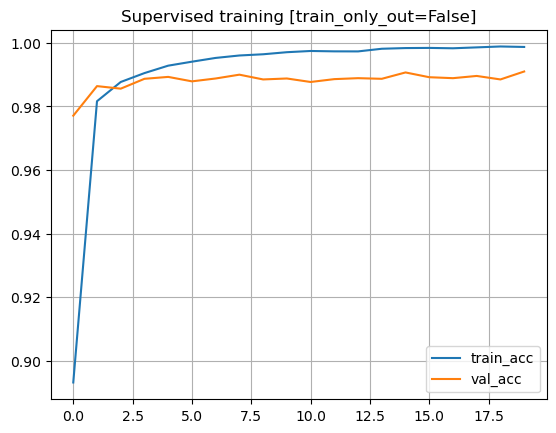

In [8]:
net1 = Net([32, 32, 64, 64, 128, 128], [2, 4])
train_net(net1, dl_train_full, dl_test)

Embedding size 128x7x7 6272


#Epoch: 19, train loss: 1.79, train_acc: 0.84, val loss: 148.83, val_acc: 0.60: 


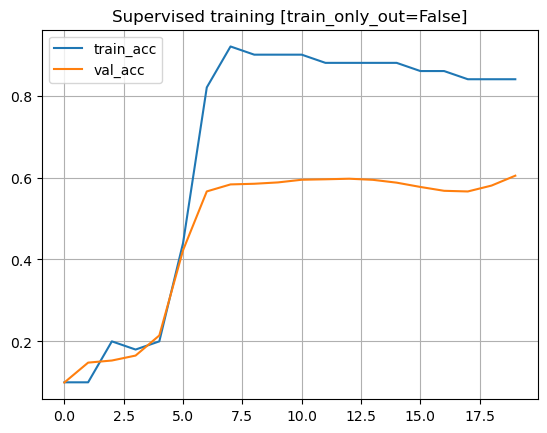

In [9]:
net2 =  Net([32, 32, 64, 64, 128, 128], [2, 4])
train_net(net2, dl_train_labeled, dl_test,)

## 2 - Cluster assumption idea

What is the similarity between objects from the same class, besides having the same class?

When passing a photo through a neural net, the model maps the photo into vectors in some latent / embedding space. The classification can be performed *because* in that latent space, examples similar to each other are close. 

### Task for you - visualize the clusters in the latent space

Write a function which, given a dataset and a model:

* processes the dataset through a model and generates embeddings of each example
* uses T-SNE to map the embeddings into points in a 2-D space 
* draw two scatterplots - one where you group embeddings by the actual class and one by predicted class
* draw different classes with different colors (and add a label <-> color legend)
* you can limit the number of points per class, e.g. to 100 to have a clearer plot

Your plot should resemble something like this:

![Grids](https://lh3.googleusercontent.com/sQB_hr2abTmwk3LC9VFY-x0VQrSxvqmZlgpWDAzsFdhoyD6pb5OmriyEImYCujhKtzY=w2400)


Please draw grids for:
* model trained on full dataset and model trained on partial dataset
* the partial dataset and the validation dataset

(all in all, 4 argument combinations)

Here is some pseudocode as a hint:

In [10]:
def draw_embeddings(net, dl: DataLoader):
  points = []
  y_true = []
  y_pred = []

  for X, y in dl:
    X = X.to(device)
    predictions, embeddings = net(X)
    y_true.append(y.detach().cpu().numpy())
    y_pred.append(predictions.detach().cpu().numpy().argmax(axis=1))
    points.append(embeddings.detach().cpu().numpy())
  
  y_true = np.concatenate(y_true)
  y_pred = np.concatenate(y_pred)
  points = np.concatenate(points)
  dim_red = TSNE(n_components=2)
  points = dim_red.fit_transform(points)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

  scatter_1 = ax1.scatter(points[:, 0], points[:, 1], c=y_true, cmap='tab10')
  legend_1 = ax1.legend(*scatter_1.legend_elements(), loc="lower left")
  ax1.add_artist(legend_1)
  scatter_2 = ax2.scatter(points[:, 0], points[:, 1], c=y_pred, cmap='tab10')
  legend_2 = ax2.legend(*scatter_2.legend_elements(), loc="lower left")

  ax1.set_title("True labels")
  ax2.set_title("Predictions")

  plt.show()

/home/tadeusz/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tadeusz/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


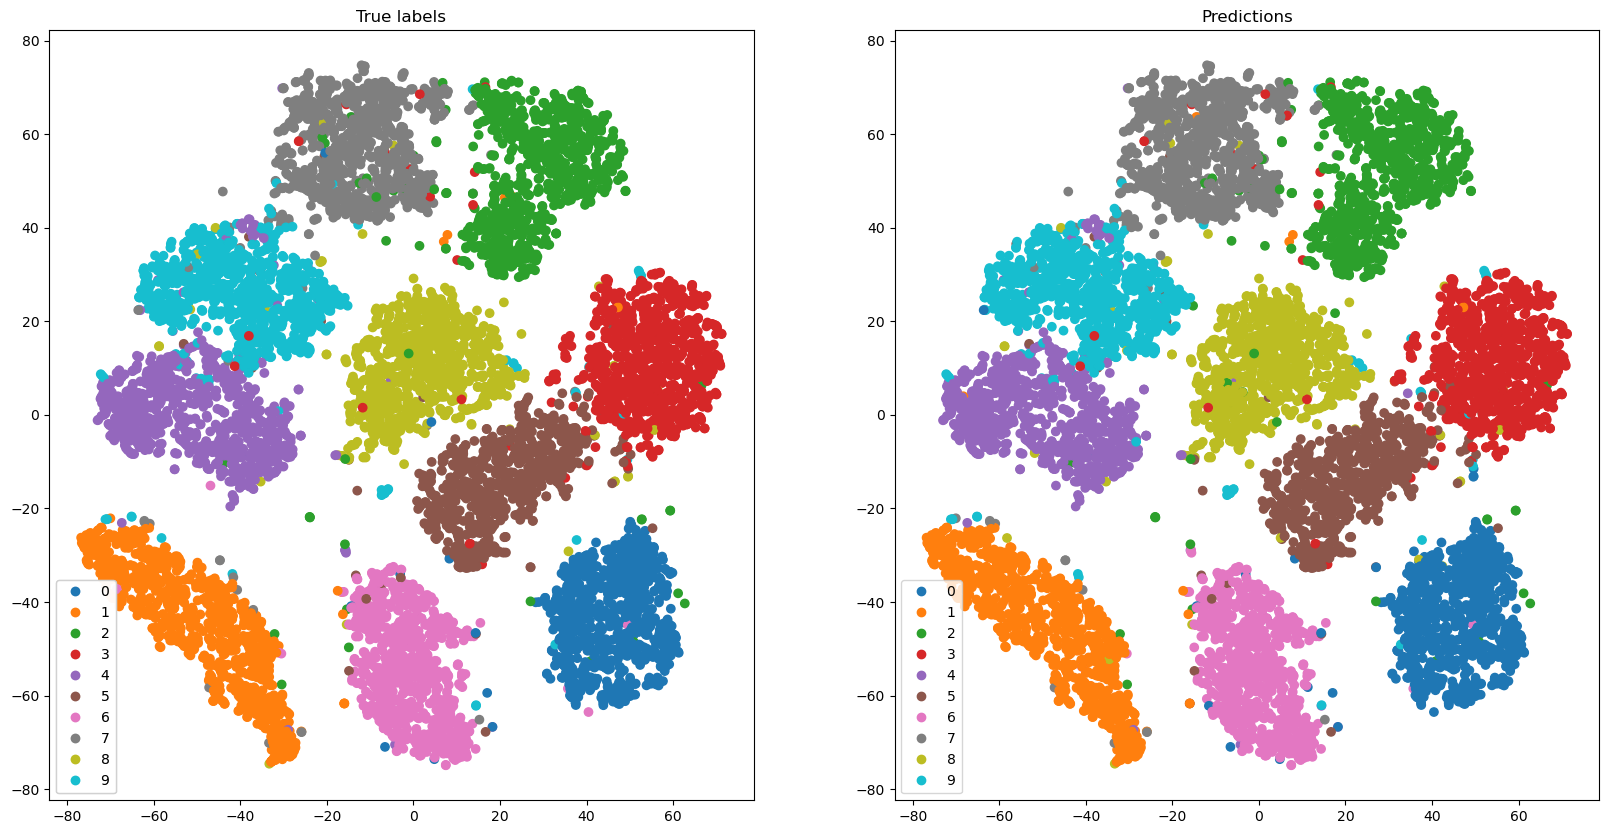

In [11]:
draw_embeddings(net1, dl_test)

/home/tadeusz/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tadeusz/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


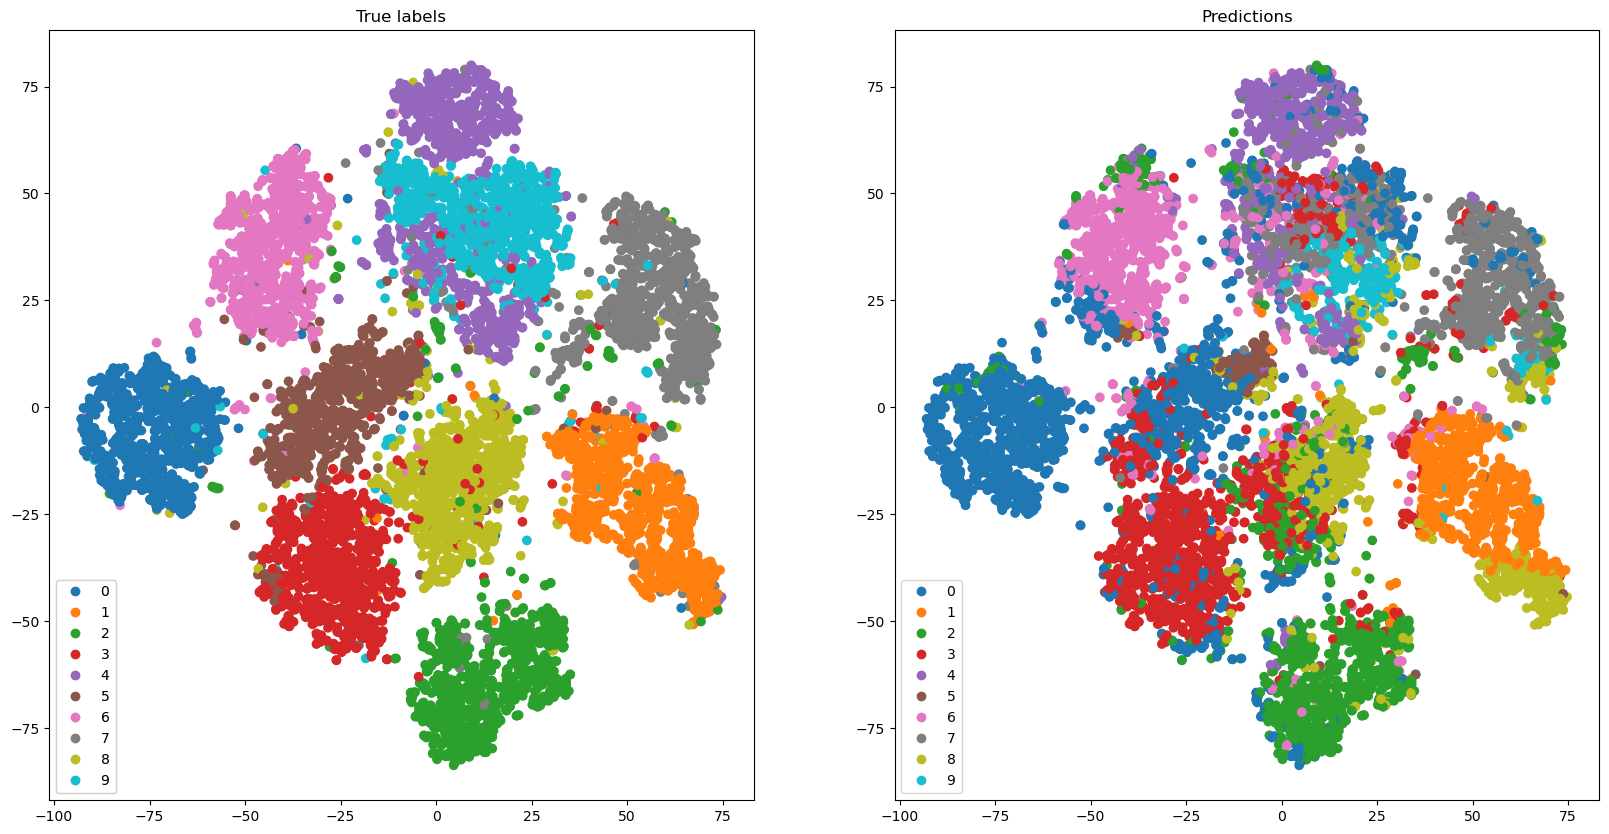

In [12]:
draw_embeddings(net2,  dl_test)

In [13]:
from torchvision import transforms, utils

## 3 - Increasing data diversity - image augmentation

The fewer training examples we have, the easier it is for the model to overfit to the data. One of the most common methods for preventing this is **data augmentation**.

### Task for you - use data augmentation

Please select 2-3 [methods of data augmentation](https://pytorch.org/vision/stable/transforms.html) and add them to the above training loop. Can you improve the model performance when training it only on the small portion of data?



Embedding size 128x7x7 6272


#Epoch: 19, train loss: 1.86, train_acc: 0.84, val loss: 152.72, val_acc: 0.57: 


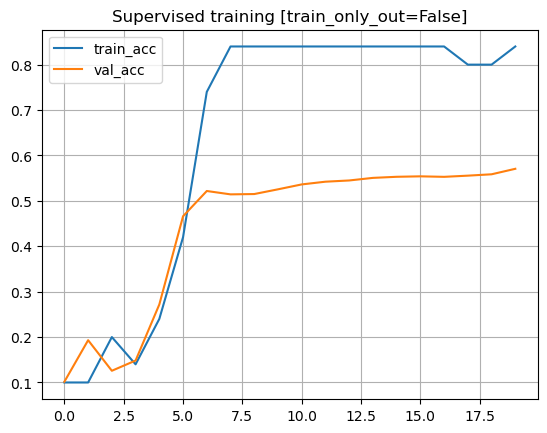

In [14]:
ds_test_augmented = Subset(
  MNIST(
    root="data", train=True, download=True,     transform=transforms.Compose([transforms.RandomCrop(20
),
    transforms.ToTensor()
])),
  labeled_indices)

dl_train_augmented = DataLoader(ds_labeled_small, batch_size, shuffle=True, drop_last=False) # dataloader with partial augmented dataset

net = Net([32, 32, 64, 64, 128, 128], [2, 4])
train_net(net, dl_train_augmented, dl_test)

## 4 - Self-supervised learning

We saw that model trained on a few data examples overfits to them and is not able to form a meaningful representation of the dataset. Can we somehow leverage the unlabeled data to improve the representation?

Yes, in more than one way! Today, we'll focus on **Self-supervised learning**.


In self-supervised learning, we can train an image encoder on **unlabeled** data to solve a **pretext task** - an artificial task where the label / value to predict data can be generated automatically.
This means that we will receive a pretrained convolutional neural network - we will need to train the final classification layer later on, separately.

Examples of pretext tasks include:
* rotating the picture and making the model predict the rotation
* turning the picture into grayscale and making the model predict the original colors

#### **Question for you** - can you come up with ideas for two other possible pretext tasks that can be generated automatically from unlabeled data?

#### **Your answer**:

In [ ]:
"for example cropping the picture and predicting the original picture or adding some noise to the picture and predicting the original picture"

### We will try out Contrastive learning and train [SimCLR](https://arxiv.org/abs/2002.05709) which is one of the best performing self-supervised techiques.

The general idea of SimCLR is to:

1. take a large batch of images (of size $B$)
2. for each image, augment it twice, in order to obtain a pair of two **different** versions of the original images
3. pass the augmented images through the encoder $E$ in order to obtain their embeddings (a total of $2B$ vectors, since each image has 2 augmented versions)
4. pass the embeddings through a **projection head** - a small fully-connected neural network separate from the encoder we are pretraining
5. calculate a matrix of similarities (e.g. cosine) between embeddings 
    * **what do elements on the diagonal correspond to? What are their values?**
6. train the model to predict embeddings such that each embedding is *the most similar to it's pair from the other augmented version of the same image*
    * **for the purpose of calculating loss, we discard similarities of embeddings to themselves - why?**
    
#### The whole process is denoted on the figure below:


<img src="https://lh4.googleusercontent.com/lRFNJNexDp6K-ub3nFH0L4KODmfnxBEXwzD1v1lA8Iz8zjf8MY5Sno1OFaAHLnJM20A=w2400" width="300"></img>

The above figure contains example augmentations applied to colored images. Are they appropriate for MNIST as well?

In [ ]:
"elements on the diagonal correspond to similarities between the picture and its exact copy, thus their values are 1 (the greatest possible cosine similarity)"

In [ ]:
"for the purpose of calculating loss, the similarities of embeddings to themselves are discarded, because as we don't consider comparing pictures to themselves, than to maintain the log probability form of the components of the final loss, we have to substract similarities of embeddings to themselves from the denominator"

### Task for you - train SimCLR on the unlabeled part of the MNIST dataset.

#### **Part 1** - choose 2-3 appropriate augmentations

Choose augmentations which you will apply to create pairs of perturbed images. 

* the images in pairs should differ visibly, but still resemble one another
* after augmentations we sould till be able to see valid digits in the images
* the augmentations should not change the image's class (don't turn 6 to 9)!

You can verify your choice of augmentations with the visualization in the cell below:

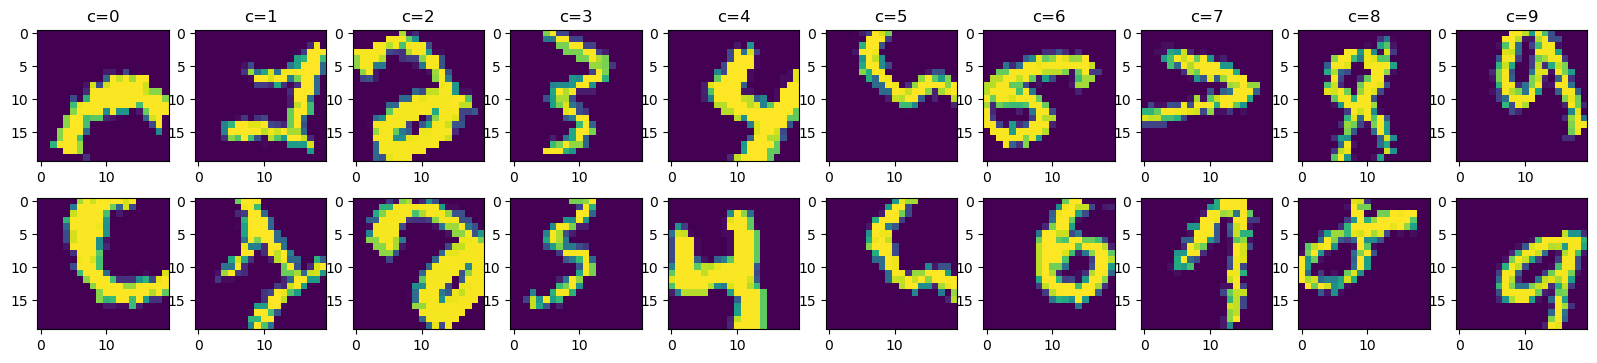

In [15]:
pre_process = [tv.RandomCrop(20), tv.RandomRotation(degrees=45), tv.ToTensor()]

trans = tv.Compose(pre_process)

# You don't need to modify the rest of the code in this cell.

def augment_twice(augmentation_pipeline):
  """An utility function which returns two perturbations of the same image"""
  def fn(X):
    return augmentation_pipeline(X), augmentation_pipeline(X)
  return fn
  

# unlabeled subset of MNIST with double-augmentations
ds_simclr_unlabeled = Subset(
  MNIST(root="data", train=True, download=True, transform=augment_twice(trans)),
  unlabeled_indices
)

dl_simclr_unlabeled = DataLoader(ds_simclr_unlabeled, 512, shuffle=True, num_workers=12)


# let's visualize your augmentations. 
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
y_plotted_target = set(list(range(10)))
y_plotted = []

for (X1, X2), y in ds_simclr_unlabeled:
  if y in y_plotted:
    continue
  ax[0][y].set_title(f"c={y}")
  ax[0][y].imshow(X1.permute(1,2,0))
  ax[1][y].imshow(X2.permute(1,2,0))
  y_plotted.append(y)
  if set(y_plotted) == y_plotted_target:
    break


In [16]:
def similarity_matrix(emb1, emb2):
  """
  An utility function for calculating cosine similarity between image embeddings. 
  You dont' need to modify it.
  Args:
    emb1, emb2: 2D embeddings tensors of shapes [B, N], [B, N] 
      
  Returns:
    a similarity matrix of shape [2B, 2B] which denotes cosine similarities between vectors from `emb1` and `emb2`
    
  """
  z1 = torch.nn.functional.normalize(emb1, dim=1)
  z2 = torch.nn.functional.normalize(emb2, dim=1)

  representations = torch.cat([z1, z2], dim=0)
  similarity_matrix = torch.nn.functional.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
  
  return similarity_matrix

#### **Part 2** - finish implementing the training loop

In [26]:
def train_simclr(
  net, repr_head, train_dl, number_of_epochs: int = 20, lr: float = 3e-4,
):
  """
  SimCLR training loop
  Args:
    * net - the encoder we are pretraining
    * repr_head - reprojection head
  """
  
  net = net.to(device)
  repr_head = repr_head.to(device)
  
  opt = torch.optim.Adam(
    [p for (n,p) in net.named_parameters() if "out" not in n] + list(reproj_head.parameters()), 
    lr=lr
  )  
  
  history = []
  epoch_progress = tqdm(list(range(number_of_epochs)))
  
  for i in epoch_progress:
      print(i)
      train_loss = 0
      y_true = []
      y_pred = []
      
      net.train()
      
      for j, ((X1, X2), _) in enumerate(train_dl):

        opt.zero_grad()
                
        assert len(X1) == len(X2)
        batch_size = len(X1)
              
        X1, X2 = X1.to(device), X2.to(device)
        opt.zero_grad()
        
        # extract the embeddings from the net (note that we care about the penultimate representation from the net here, which is returned as the second element)
        _, e1 = net(X1) 
        _, e2 = net(X2)
        
        # pass the embeddings through the reprojection head
        r1, r2 = repr_head(e1), repr_head(e2)
        
        # calculate the similarities between embeddings (a matrix of shape )
        sim_matrix = similarity_matrix(r1, r2)
           
        sim_matrix.fill_diagonal_(0)
        
        labels = torch.zeros((2*batch_size, 2*batch_size)).to(device)
        for i in range(batch_size):
            labels[i][i+batch_size] = 1
            labels[batch_size+i][i] = 1
        
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(sim_matrix, labels)
        
        print(loss)
        
        loss.backward()
        opt.step()
        
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(sim_matrix.argmax(1).detach().cpu().numpy())
        train_loss +=loss.item()
      
      acc = accuracy_score(y_true, y_pred)
      history.append({"e": i, "train_loss" : train_loss, "train_acc": acc})
      epoch_progress.set_description(f"#Epoch: {i}, train loss: {train_loss:.2f}, train_acc: {acc:.2f}")

  
  fig, ax = plt.subplots(ncols=2)
  ax[0].plot([h["e"] for h in history], [h["train_loss"] for h in history], label="train_loss")
  ax[1].plot([h["e"] for h in history], [h["train_acc"] for h in history], label="train_acc")
  
  [a.grid() for a in ax], [a.legend() for a in ax]
  plt.suptitle("SimCLR training")
  plt.show()

  return net        

#### **Part 4** - pretrain a network with SimCLR!
In order to achieve the best accuracy in part 5 (see below), you can play with several hyperparameters:
* try out different batch sizes (should the batch size in SimCLR be large or small?)
* different augmentations pipelines (see part 1)
* different architectures of reprojection head
* different numbers of epochs / learning rates

In [29]:
# SETUP:

# the augmentation setup is repeated here for your convenience, so that you can have the complete setup here
pre_process = [tv.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5), tv.RandomRotation(degrees=45), tv.ToTensor()]

trans = tv.Compose(pre_process)
    
# YOUR CODE HERE - you can copy the selected augmentations from part 1


# unlabeled subset of MNIST with double-augmentations
ds_simclr_unlabeled = Subset(
  MNIST(root="data", train=True, download=True, transform=augment_twice(trans)),
  unlabeled_indices
)
# dataset loader
dl_simclr_unlabeled = DataLoader(ds_simclr_unlabeled, 512, shuffle=True, num_workers=12)

################################################
net_simclr =  Net([32, 32, 64, 64, 128, 128], [2, 4])
################################################

# this is a suggested reprojection head, you're welcome to try out other architectures!
reproj_head = nn.Sequential(
  nn.Linear(net_simclr.embedding_dim, 64), 
  nn.ReLU(),
  nn.Linear(64, 64), 
)

Embedding size 128x7x7 6272


In [ ]:
# fill out your network architecture - for fair comparison it should be the same as the one you've trained the supervised way
net_simclr =  Net([32, 32, 64, 64, 128, 128], [2, 4])

# run the pretraining
net_simclr = train_simclr(
  net_simclr, reproj_head, train_dl=dl_simclr_unlabeled, number_of_epochs=45, lr=1e-2, 
)

# save the state of the pretrained network in order not to retrain it every time
simclr_state = {
  k: v.clone() 
  for (k,v) in 
  net_simclr.state_dict().items()
}

Embedding size 128x7x7 6272


  0%|                                                    | 0/45 [00:00<?, ?it/s]

0
tensor(6.9309, grad_fn=<DivBackward1>)
tensor(6.9301, grad_fn=<DivBackward1>)
tensor(6.9246, grad_fn=<DivBackward1>)
tensor(6.8441, grad_fn=<DivBackward1>)
tensor(6.7772, grad_fn=<DivBackward1>)
tensor(6.8437, grad_fn=<DivBackward1>)
tensor(6.6893, grad_fn=<DivBackward1>)
tensor(6.5558, grad_fn=<DivBackward1>)
tensor(6.5348, grad_fn=<DivBackward1>)
tensor(6.5106, grad_fn=<DivBackward1>)
tensor(6.4819, grad_fn=<DivBackward1>)
tensor(6.4251, grad_fn=<DivBackward1>)
tensor(6.4148, grad_fn=<DivBackward1>)
tensor(6.3944, grad_fn=<DivBackward1>)
tensor(6.3715, grad_fn=<DivBackward1>)
tensor(6.3602, grad_fn=<DivBackward1>)
tensor(6.3439, grad_fn=<DivBackward1>)
tensor(6.3291, grad_fn=<DivBackward1>)
tensor(6.3000, grad_fn=<DivBackward1>)
tensor(6.2766, grad_fn=<DivBackward1>)
tensor(6.2852, grad_fn=<DivBackward1>)
tensor(6.2617, grad_fn=<DivBackward1>)
tensor(6.2263, grad_fn=<DivBackward1>)
tensor(6.2341, grad_fn=<DivBackward1>)
tensor(6.2142, grad_fn=<DivBackward1>)
tensor(6.2240, grad_fn=

#### **Part 5** - explore the representations learned by the network

Use the `draw_embeddings` function to visualize the representation learned by your model. Does it learn to group images from the same classes together, even though it was never trained in the supervised fashion?

#### **Part 6** - finetune the pretrained network on the small MNIST subset
You can try out two approaches:
* train the entire network
* train the params of only the final layer

**You should achieve at least 80% validation accuracy**

In [ ]:
net_simclr.load_state_dict(simclr_state)
train_net(net_simclr, dl_train_labeled, dl_test, number_of_epochs =100, train_only_out=True)

In [ ]:
net_simclr.load_state_dict(simclr_state)

train_net(net_simclr, dl_train_labeled, dl_test, number_of_epochs =100)

## References
This notebook was partially inspired by [this blogpost](https://zablo.net/blog/post/understanding-implementing-simclr-guide-eli5-pytorch/).